In [ ]:
pip install -r requirements.txt

In [45]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import nengo_dl 
import nengo
import matplotlib.pyplot as plt

In [21]:
test_data = pd.read_csv("./heartbeat/mitbih_test.csv", header=None)
train_data = pd.read_csv("./heartbeat/mitbih_train.csv", header=None)
train_data.shape

(87554, 188)

# From TensorFlow Sequential Models to Spiking Neural Networks

We are going to use a TensorFlow sequential model to generate a Nengo spiking neural network. Spiking neural networks can achieve high accuracy with synaptic smoothing and a high firing rate, however, they need multiple iterations of the test data to go through before they learn. 

We use a model with a few convolutional layers to start with to filter the noisy signal. These few layers give us an accuracy of 100% in training and 97% in test. For the SNN, we obtain accuracies of 95% in training, while in evaluation accuracies are extremely low. This is for a number of reasons including that the sparse accuracy metric is looking at all the steps rather than the last step of the tiled data that needs to be prepared for the network to operated. 

## Bias

The overrepresentation of normal EEG signals might allow for the model to achieve high accuracy by learning to predict normal extensively. In our case this didn't affect our results significantly due to our extensive filtering. 

In [4]:
model = tf.keras.models.Sequential([ tf.keras.layers.Conv1D(64, (3), activation='relu', padding="same", input_shape=(1,187)),
                                      tf.keras.layers.MaxPooling1D(2, padding="same"),
                                      tf.keras.layers.Conv1D(64, (3), padding="same", activation='relu'),
                                      tf.keras.layers.MaxPooling1D(2, padding="same"),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             35968     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [ ]:
# Only run the below code if you're using TensorFlow model and no Nengo networks

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
x_train = train_data.loc[:,train_data.columns!= 187]
y_train = train_data[train_data.columns[-1]]
x_test = test_data.loc[:,test_data.columns!= 187]
y_test = test_data[test_data.columns[-1]]


np.unique(y_train, return_counts=True)[1]


array([72471,  2223,  5788,   641,  6431])

Recall that the data is heavily unbalanced and could bias our spiking neural network to predicting normal ECG too often. Let's try balancing the data through removal of normal signals.

SNNs are particularly sensitive to unbalanced data, though interestingly our original TensorFlow model is not, and has high accuracy (~100%) on the unbalanced data set. 

In [64]:
# Only run this cell if you want to balance the data before training and testing

# counts = np.unique(y_train, return_counts=True)[1]
# avg_of_non_normal = counts[1:].mean()
# num_train_rows_to_eliminate = counts[0] - avg_of_non_normal

# counts = np.unique(y_test, return_counts=True)[1]
# avg_of_non_normal = counts[1:].mean()
# num_test_rows_to_eliminate = counts[0] - avg_of_non_normal
# num_train_rows_to_eliminate

68700.25

In [22]:
#comment the code in this cell out if you're not balacing the data by deleting most of the normal rows.
# x_train = train_data.loc[int(num_train_rows_to_eliminate):,train_data.columns!= 187]
# y_train = x_train[x_train.columns[-1]]

# x_test = test_data.loc[int(num_test_rows_to_eliminate):,test_data.columns!= 187]
# y_test = x_test[x_test.columns[-1]]


NameError: name 'num_train_rows_to_eliminate' is not defined

In [16]:
#If using tensorflow only and not Nengo run the following two lines and comment the nengo lines

# x_train = x_train.values.reshape(-1, 1, x_train.shape[1])

# x_test = x_test.values.reshape(-1, 1, x_test.shape[1])



In [ ]:
y_train

In [24]:
#If using Nengo run these lines

x_train = x_train.values[:, None, :]
y_train = y_train.values[:, None, None]

x_test = x_test.values[:, None, :]
y_test = y_test.values[:, None, None]

In [ ]:
# Only run the below code if you're just using TensorFlow and no Nengo network

# model.fit(x_train,y_train, epochs=30)

In [ ]:
# Only run the below code if you're just using TensorFlow and no Nengo network
# model.evaluate(x_test, y_test)

In [ ]:
# If you want to build the Nengo network without sequential, uncomment the following and get rid of the "do Training" cell: 

# with nengo.Network() as net:
#     # input node, same as before
#     inp = nengo.Node(output=np.ones(187))
    
#     hidden0 = nengo_dl.Layer(tf.keras.layers.Conv1D(64, (3), activation='relu', padding="same"))(inp)
#     hidden1 = nengo_dl.Layer(tf.keras.layers.MaxPooling1D(2, padding="same"))(hidden0,shape_in=(1,64))                                 
#     hidden2 = nengo_dl.Layer(tf.keras.layers.Conv1D(64, (3), activation='relu', padding="same"))(hidden1, shape_in=(1,64))                             ,
#     hidden3 = nengo_dl.Layer(tf.keras.layers.MaxPooling1D(2, padding="same"))(hidden2, shape_in=(1,64))

#     # add the Dense layers, as in the Keras model
#     hidden4 = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
#         hidden3
#     )
#     out = nengo_dl.Layer(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax))(hidden4)

#     # add a probe to collect output
#     out_p = nengo.Probe(out)


In [7]:
converter = nengo_dl.Converter(model, max_to_avg_pool=True)

/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:924: UserWarning: Converting sequential model to functional model; use `Converter.model` to refer to the functional model (rather than the original sequential model) when working with the output of the Converter
  "Converting sequential model to functional model; "
/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:325: UserWarning: max_pooling1d.padding has value same != valid, which is not supported. Falling back to TensorNode.
  f"{error_msg + '. ' if error_msg else ''}"
/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:325: UserWarning: max_pooling1d_1.padding has value same != valid, which is not supported. Falling back to TensorNode.
  f"{error_msg + '. ' if error_msg else ''}"
/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:587: UserWarning: Activation type <function softmax_v2 at 0x7fa850744440> does not have a native Nengo equivalent; falling back to a TensorNode
  f"Activation type 

We obtain particularly good performance during training, but accuracy is not the right exact metric for this problem considering the imbalanced dataset and the fact that TensorFlow's accuracy metric does not support multiclass classifcation problems.

In [8]:
do_training = True
if do_training:
    with nengo_dl.Simulator(converter.net) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss='sparse_categorical_crossentropy',
            metrics='accuracy',
        )
        sim.fit(x_train, y_train, epochs=2)
        sim.evaluate(x_test, y_test)
        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    # download pretrained weights
    sim.load_params("./keras_to_snn_params")
    print("Loaded pretrained weights")


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#####         Constructing graph: build stage (8%)              | ETA: 0:00:00

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Construction finished in 0:00:00                                               


/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1766: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (4); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  f"Number of elements ({len(data)}) in "


Epoch 1/2
   37/87554 [..............................] - ETA: 6:19 - loss: 1.0153 - probe_loss: 1.0153 - probe_accuracy: 0.8378      


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=4

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'

87554/87554 [==============================] - 358s 4ms/step - loss: 0.2518 - probe_loss: 0.2518 - probe_accuracy: 0.9319
Epoch 2/2
21892/21892 [==============================] - 61s 3ms/step - loss: 0.1867 - probe_loss: 0.1867 - probe_accuracy: 0.9545


## Converting to a Spiking Neural Network

For testing purposes, we're going to convert our existing directly ported nengo network which uses relu activation functions to a spiking neural network which converts these to nengo Spiking Rectified Linear activation functions. 

Some hyperparameter optimizations were applied here after an initial run with `synapse = None` and `scale_firing_rates = None`. The `synapse` parameter controls the low-pass synaptic filtering done on the signals. More filtering reduces the loss, similar to how convolutional layers reduce error by boosting signal-to-noise ratio. The `scale_firing_rates` parameter governs the firing rate of the neurons in the network. Higher firing rates lead to higher accuraccy because of the way the signal is propogated, as they do in non-artificial neural networks. 

In [60]:
scale_firing_rates = 35
synapse = .01
    
nengo_converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear(),  tf.keras.activations.relu: nengo.SpikingRectifiedLinear() },
    scale_firing_rates=scale_firing_rates,
    synapse=synapse,
)

/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:924: UserWarning: Converting sequential model to functional model; use `Converter.model` to refer to the functional model (rather than the original sequential model) when working with the output of the Converter
  "Converting sequential model to functional model; "
/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:325: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  f"{error_msg + '. ' if error_msg else ''}"
/opt/conda/lib/python3.7/site-packages/nengo_dl/converter.py:587: UserWarning: Activation type <function softmax_v2 at 0x7fa850744440> does not have a native Nengo equivalent; falling back to a TensorNode
  f"Activation type {activation} does not have a native Nengo "


In [61]:
n_steps=30

In [11]:
#We set a probe to record neurons for visualization purposes at the first convolutional layer. 

sample_neurons = np.linspace(
        0,
        np.prod(model.layers[1].output.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
with nengo_converter.net:
    conv1d_probe = nengo.Probe(nengo_converter.layers[model.layers[0].get_output_at(-1)])


In [34]:
tiled_x_test = np.tile(x_test, (1, n_steps, 1))
tiled_y_test = np.tile(y_test, (1, n_steps, 1))

In [62]:
 with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

In [63]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])
 
    
with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params('./keras_to_snn_params')
        nengo_sim.compile(loss=classification_accuracy, metrics="sparse_categorical_accuracy")
        nengo_sim.evaluate(tiled_x_test, tiled_y_test)


2189/2189 [==============================] - 82s 37ms/step - loss: 0.7116 - probe_loss: 0.7116 - probe_sparse_categorical_accuracy: 0.6913


KeyError: (<Reference wrapping <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>>,)

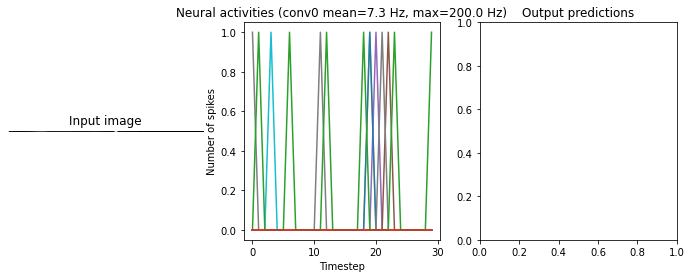

In [52]:
# plotting performance, unfinished
# for ii in range(3):
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 3, 1)
#     plt.title("Input image")
#     plt.imshow(x_test[ii, 0].reshape((1, 187)), cmap="gray")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     scaled_data = data[conv1d_probe][ii] * scale_firing_rates
#     scaled_data *= 0.001
#     rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
#     plt.ylabel("Number of spikes")
#     plt.xlabel("Timestep")
#     plt.title(
#         f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
#         f"max={rates.max():.1f} Hz)"
#     )
#     plt.plot(scaled_data)

#     plt.subplot(1, 3, 3)
#     plt.title("Output predictions")
#     plt.plot(tf.nn.softmax(data[nengo_converter.outputs[model.layers[5].get_output_at(-1)]]))
#     plt.legend([str(j) for j in range(10)], loc="upper left")
#     plt.xlabel("Timestep")
#     plt.ylabel("Probability")

#     plt.tight_layout()
